In [1]:
import pandas as pd

# 1. Importing and cleaning data
pfc_file = pd.read_csv("NSE_PFC_EQ_candlestick_data.csv")
recltd_file = pd.read_csv("NSE_RECLTD_EQ_candlestick_data.csv")

merged_data = pd.merge(pfc_file, recltd_file, on='timestamp', suffixes=('_PFC', '_RECLTD'))
merged_data = merged_data.sort_values('timestamp')
merged_data = merged_data.reset_index(drop=True)
merged_data = merged_data.dropna()
merged_data['timestamp'] = pd.to_datetime(merged_data['timestamp']).dt.tz_localize('Asia/Kolkata')


In [2]:
import numpy as np

# 2. Calculating log returns and Adjusting with Hedge Ratio
import numpy as np
import statsmodels.api as sm

merged_data['log_close_PFC'] = np.log(merged_data['close_PFC'])
merged_data['log_close_RECLTD'] = np.log(merged_data['close_RECLTD'])

merged_data['log_returns_PFC'] = merged_data['log_close_PFC'].diff()
merged_data['log_returns_RECLTD'] = merged_data['log_close_RECLTD'].diff()

# Estimate hedge ratio: regress log_close_PFC on log_close_RECLTD
X = sm.add_constant(merged_data['log_close_RECLTD'])
model = sm.OLS(merged_data['log_close_PFC'], X, missing='drop').fit()
hedge_ratio = model.params['log_close_RECLTD']

# Calculate the spread using the hedge ratio
merged_data['spread'] = merged_data['log_close_PFC'] - hedge_ratio * merged_data['log_close_RECLTD']
print(hedge_ratio)

0.901396988504972


In [3]:
!pip install --upgrade nbformat

In [4]:
import plotly.graph_objects as go

# 3. Calculating correlation
correlation = merged_data['log_returns_PFC'].corr(merged_data['log_returns_RECLTD'])
print(f"Correlation between PFC and RECLTD: {correlation}")

rolling_correlation = merged_data['log_returns_PFC'].rolling(window=30).corr(merged_data['log_returns_RECLTD'])

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=merged_data['timestamp'],
        y=rolling_correlation,
        mode='lines',
        name='30-Day Rolling Correlation'
    )
)

fig.update_layout(
    title='30-Day Rolling Correlation between PFC and RECLTD Returns',
    xaxis_title='Date',
    yaxis_title='Correlation',
    showlegend=True,
    width=1200,
    height=600
)

fig.show()
print(rolling_correlation)

Correlation between PFC and RECLTD: 0.9094079366974991


0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
570    0.867305
571    0.861655
572    0.886219
573    0.870627
574    0.871515
Length: 575, dtype: float64


In [5]:
from statsmodels.tsa.stattools import coint 

# 4. Calculating Cointegration
score, pvalue, _ = coint(merged_data['close_PFC'], merged_data['close_RECLTD'])

print("\nCointegration Test Results:")
print(f"Test Statistic: {score}")
print(f"P-value: {pvalue}")
print(f"The series are {'cointegrated' if pvalue < 0.05 else 'not cointegrated'} at 5% significance level")



Cointegration Test Results:
Test Statistic: -4.701731090198283
P-value: 0.0005600195469049297
The series are cointegrated at 5% significance level


Understand the Above Maths in Depth

In [6]:
from statsmodels.tsa.stattools import adfuller

# 5. Calculate Spread
# merged_data['spread'] = np.log(merged_data['close_PFC']) - np.log(merged_data['close_RECLTD'])
# It's calculated above

# 6. Running ADF test
def adf_test(series, title=''):
    print(f"\nAugmented Dickey-Fuller Test Results for {title}:")
    result = adfuller(series.dropna())
    
    adf_statistic = result[0]
    p_value = result[1]
    critical_values = result[4]
    
    print('ADF Statistic:', adf_statistic)
    print('p-value:', p_value)
    print('Critical values:')
    for key, value in critical_values.items():
        print(f'\t{key}: {value}')
    print(f"The series is {'stationary' if p_value < 0.05 else 'non-stationary'} at 5% significance level")
    
    return adf_statistic, p_value, critical_values

# 7. Calculate Hurst Exponent
def hurst_exponent(time_series, lags=range(2, 100)):
    tau = []
    lagvec = []
    
    # Remove NaN values
    time_series = time_series.dropna()
    
    # Calculate the array of the variances of the lagged differences
    for lag in lags:
        # Calculate price difference
        pp = np.subtract(time_series[lag:].values, time_series[:-lag].values)
        # Calculate variance of the difference
        lagvec.append(lag)
        tau.append(np.sqrt(np.std(pp)))
    
    # Calculate the slope of the log plot -> the Hurst Exponent
    m = np.polyfit(np.log10(lagvec), np.log10(tau), 1)
    hurst = m[0]
    return hurst

# Calculate and print Hurst exponent for the spread
hurst = hurst_exponent(merged_data['spread'])
print("\nHurst Exponent Analysis:")
print(f"Hurst Exponent: {hurst:.4f} (H<0.5: Mean-reverting, H=0.5: Random walk, H>0.5: Trending)")

# Perform ADF test on the spread
adf_statistic, p_value, critical_values = adf_test(merged_data['spread'], 'Spread')



Hurst Exponent Analysis:
Hurst Exponent: 0.1601 (H<0.5: Mean-reverting, H=0.5: Random walk, H>0.5: Trending)

Augmented Dickey-Fuller Test Results for Spread:
ADF Statistic: -3.639621294971477
p-value: 0.005047199130425345
Critical values:
	1%: -3.4418948967017475
	5%: -2.8666329082535222
	10%: -2.569482366838501
The series is stationary at 5% significance level


# Important
1. test_merged_data = merged_data
2. test_merged_data['spread'] = merged_data['log_returns_PFC'] - merged_data['log_returns_RECLTD']
3. There is no differnce in results if calculated this way also, understand why and how the maths is working

In [7]:
# 8. Calculate Z-Score
merged_data.head()

,timestamp,open_PFC,high_PFC,low_PFC,close_PFC,open_RECLTD,high_RECLTD,low_RECLTD,close_RECLTD,log_close_PFC,log_close_RECLTD,log_returns_PFC,log_returns_RECLTD,spread
0,2023-01-02 05:30:00+05:30,113.96,120.44,112.92,119.76,117.80,120.75,117.00,120.40,4.785490,4.790820,NaN,NaN,0.467059
1,2023-01-03 05:30:00+05:30,120.72,126.24,119.72,124.80,121.25,123.90,119.75,123.00,4.826712,4.812184,0.041223,0.021365,0.489024
2,2023-01-04 05:30:00+05:30,125.60,125.68,121.36,123.60,122.85,123.85,119.95,122.20,4.817051,4.805659,-0.009662,-0.006525,0.485244
3,2023-01-05 05:30:00+05:30,123.60,126.40,122.08,125.52,122.90,124.25,121.05,123.85,4.832465,4.819071,0.015415,0.013412,0.488569
4,2023-01-06 05:30:00+05:30,126.12,128.64,123.36,125.72,124.35,126.10,122.60,123.70,4.834057,4.817859,0.001592,-0.001212,0.491253


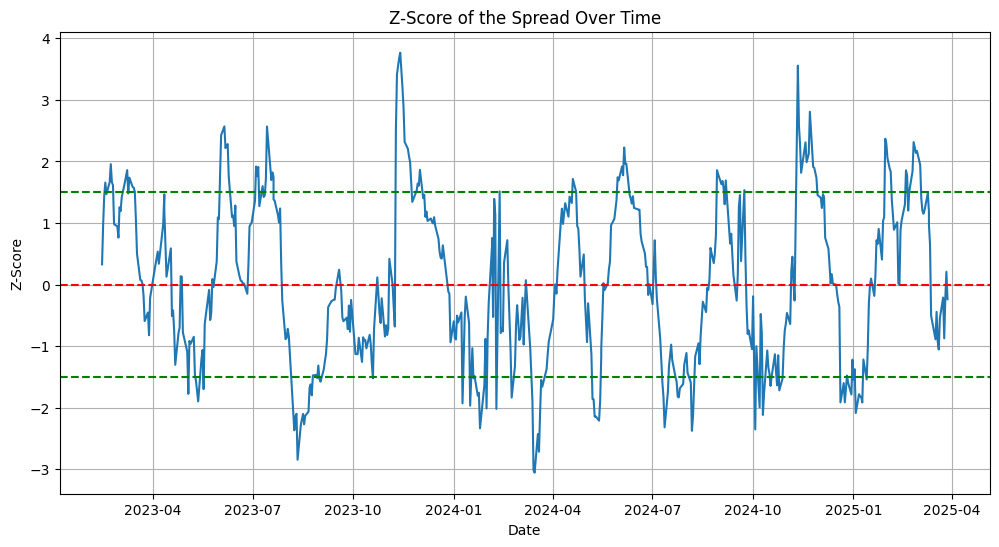

In [8]:
import matplotlib.pyplot as plt

# 8. Calculating Z-Score
# Calculate 30-day rolling mean and standard deviation of the spread
merged_data['spread_rolling_mean'] = merged_data['spread'].rolling(window=30).mean()
merged_data['spread_rolling_std']  = merged_data['spread'].rolling(window=30).std()
# Calculate the z-score of the spread
merged_data['z_score'] = (merged_data['spread'] - merged_data['spread_rolling_mean']) / merged_data['spread_rolling_std']
# Plot the Z-score
plt.figure(figsize=(12, 6))
plt.plot(merged_data['timestamp'], merged_data['z_score'])
plt.axhline(y=0, color='r', linestyle='--')
plt.axhline(y=1.5, color='g', linestyle='--')
plt.axhline(y=-1.5, color='g', linestyle='--')
plt.title('Z-Score of the Spread Over Time')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.grid(True)
plt.show()

# Plot the Z-score from Jan 31, 2022 onwards using plotly
import plotly.graph_objects as go

start_date = '2022-01-31'
filtered_data = merged_data[merged_data['timestamp'] >= start_date]

fig = go.Figure()

# Add Z-score line
fig.add_trace(go.Scatter(
    x=filtered_data['timestamp'],
    y=filtered_data['z_score'],
    mode='lines',
    name='Z-Score'
))

# Add horizontal lines
fig.add_hline(y=0, line_dash="dash", line_color="red")
fig.add_hline(y=1.5, line_dash="dash", line_color="green")
fig.add_hline(y=-1.5, line_dash="dash", line_color="green")

# Update layout
fig.update_layout(
    title='Z-Score of the Spread (Jan 31, 2022 onwards)',
    xaxis_title='Date',
    yaxis_title='Z-Score',
    showlegend=True,
    template='plotly_white'
)

fig.show()


In [9]:
import pandas as pd
import plotly.graph_objects as go

# Set the path to your final dataset CSV file
file_path = "PFC_RECLTD_feature_set.csv"

# Load the dataset (parsing 'timestamp' as datetime) and ensure it's in chronological order
df = pd.read_csv(file_path, parse_dates=['timestamp'])
df = df.sort_values('timestamp')

# Localize start_date to the same timezone as the timestamp column
start_date = pd.to_datetime("2024-04-01").tz_localize("Asia/Kolkata")

# Filter dataset for timestamps on or after April 1, 2024
df_filtered = df[df['timestamp'] >= start_date]

# Calculate normalized elo_diff: (value - mean) / std for the filtered data
df_filtered['normalized_elo_diff'] = (df_filtered['elo_diff'] - df_filtered['elo_diff'].mean()) / df_filtered['elo_diff'].std()

# Create a Plotly figure
fig = go.Figure()

# Plot normalized elo_diff
fig.add_trace(go.Scatter(
    x=df_filtered['timestamp'], 
    y=df_filtered['normalized_elo_diff'],
    mode='lines',
    name='Normalized Elo Difference',
    line=dict(color='blue')
))

# Plot z_score
fig.add_trace(go.Scatter(
    x=df_filtered['timestamp'], 
    y=df_filtered['z_score'],
    mode='lines',
    name='Z-Score',
    line=dict(color='red')
))

# Customize the layout of the plot
fig.update_layout(
    title='Normalized Elo Difference and Z-Score Over Time (After April 2024)',
    xaxis_title='Date',
    yaxis_title='Normalized Value',
    template="plotly_white",
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

# Show the interactive plot
fig.show()

/var/folders/cr/4c9jg_px6xnb841_l3_k44x40000gn/T/ipykernel_44882/4001560824.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [11]:
import numpy as np
import pandas as pd

# -----------------------------
# 1. Trade Log Generation with Beta-Adjusted RECLTD Prices
# -----------------------------
# Assume that beta (the hedge ratio) has been computed earlier,
# e.g., beta = model.params['log_close_RECLTD']

# Calculate rolling mean and standard deviation for the spread
merged_data['spread_mean'] = merged_data['spread'].rolling(window=30).mean()
merged_data['spread_std'] = merged_data['spread'].rolling(window=30).std()

# Compute z-score of the spread
merged_data['z_score'] = (merged_data['spread'] - merged_data['spread_mean']) / merged_data['spread_std']

# Initialize an empty trade log list
trades = []

# Variables to hold details for an active trade
position = None          # "short_spread" (entry when z > +2) or "long_spread" (entry when z < -2)
entry_date = None
entry_z = None
entry_pfc = None         # PFC's closing price at entry
entry_recltd = None      # RECLTD's closing price adjusted by beta at entry

# Loop through DataFrame rows to record trades
for i in range(1, len(merged_data)):
    z = merged_data.loc[i, 'z_score']
    date = merged_data.loc[i, 'timestamp']
    
    # Use beta-adjusted RECLTD price
    current_pfc = merged_data.loc[i, 'close_PFC']
    current_recltd = beta * merged_data.loc[i, 'close_RECLTD']  # Adjust RECLTD price with beta
    
    # Entry conditions (only when no active position exists)
    if position is None:
        if z > 2:
            # For z-score > +2, enter a short_spread trade:
            # Short PFC and Long RECLTD
            position = 'short_spread'
            entry_date = date
            entry_z = z
            entry_pfc = current_pfc
            entry_recltd = current_recltd
        elif z < -2:
            # For z-score < -2, enter a long_spread trade:
            # Long PFC and Short RECLTD
            position = 'long_spread'
            entry_date = date
            entry_z = z
            entry_pfc = current_pfc
            entry_recltd = current_recltd
    else:
        # Exit conditions based on the active position:
        if position == 'short_spread' and z < -2:
            # Exit for short_spread: when the z-score crosses below -2.
            exit_date = date
            exit_z = z
            exit_pfc = current_pfc
            exit_recltd = current_recltd
            # For a short_spread trade, the profit is:
            # Profit = (Entry PFC - Exit PFC) + beta * (Exit RECLTD - Entry RECLTD)
            pnl = (entry_pfc - exit_pfc) + (exit_recltd - entry_recltd)
            trades.append({
                'Position': position,
                'Entry Date': entry_date,
                'Entry Z-Score': entry_z,
                'Entry PFC Price': entry_pfc,
                'Entry Adjusted RECLTD Price': entry_recltd,
                'Exit Date': exit_date,
                'Exit Z-Score': exit_z,
                'Exit PFC Price': exit_pfc,
                'Exit Adjusted RECLTD Price': exit_recltd,
                'PnL': pnl
            })
            # Reset active trade details
            position = None
            entry_date = None
            entry_z = None
            entry_pfc = None
            entry_recltd = None
            
        elif position == 'long_spread' and z > 2:
            # Exit for long_spread: when the z-score crosses above +2.
            exit_date = date
            exit_z = z
            exit_pfc = current_pfc
            exit_recltd = current_recltd
            # For a long_spread trade, the profit is:
            # Profit = (Exit PFC - Entry PFC) + beta * (Entry RECLTD - Exit RECLTD)
            pnl = (exit_pfc - entry_pfc) + (entry_recltd - exit_recltd)
            trades.append({
                'Position': position,
                'Entry Date': entry_date,
                'Entry Z-Score': entry_z,
                'Entry PFC Price': entry_pfc,
                'Entry Adjusted RECLTD Price': entry_recltd,
                'Exit Date': exit_date,
                'Exit Z-Score': exit_z,
                'Exit PFC Price': exit_pfc,
                'Exit Adjusted RECLTD Price': exit_recltd,
                'PnL': pnl
            })
            # Reset active trade details
            position = None
            entry_date = None
            entry_z = None
            entry_pfc = None
            entry_recltd = None

# Convert the trade log list into a DataFrame
trade_log_df = pd.DataFrame(trades)

# Calculate the cumulative PnL by summing individual trade PnLs
cumulative_pnl = trade_log_df['PnL'].sum()

# -----------------------------
# 2. Compute Performance Metrics
# -----------------------------
# Ensure that the date columns are in datetime format
trade_log_df['Entry Date'] = pd.to_datetime(trade_log_df['Entry Date'])
trade_log_df['Exit Date'] = pd.to_datetime(trade_log_df['Exit Date'])

# Average Holding Period in days
trade_log_df['Holding Period'] = (trade_log_df['Exit Date'] - trade_log_df['Entry Date']).dt.days
average_holding_period = trade_log_df['Holding Period'].mean()

# Profit Factor (sum of winning trades divided by absolute sum of losing trades)
wins = trade_log_df.loc[trade_log_df['PnL'] > 0, 'PnL'].sum()
losses = trade_log_df.loc[trade_log_df['PnL'] < 0, 'PnL'].sum()  # this is negative if there are losses
profit_factor = wins / abs(losses) if losses != 0 else np.nan

# Winning Percentage
winning_percentage = (trade_log_df['PnL'] > 0).mean() * 100

# Build an Equity Curve from the trades:
# We'll use the exit dates and cumulative PnL.
trade_log_df = trade_log_df.sort_values('Exit Date')
cumulative_pnl_series = trade_log_df.set_index('Exit Date')['PnL'].cumsum()

# Create a daily equity curve from the first trade's entry date to the last trade's exit date
start_date = trade_log_df['Entry Date'].min()
end_date = trade_log_df['Exit Date'].max()
dates = pd.date_range(start=start_date, end=end_date, freq='D')
equity_curve = pd.DataFrame(index=dates, columns=['Cumulative PnL'])
equity_curve['Cumulative PnL'] = cumulative_pnl_series.reindex(equity_curve.index, method='ffill').fillna(0)

# Compute Daily Returns for the equity curve
equity_curve['Daily Return'] = equity_curve['Cumulative PnL'].pct_change().fillna(0)

# Maximum Drawdown calculation:
equity_curve['Cumulative Max'] = equity_curve['Cumulative PnL'].cummax()
equity_curve['Drawdown'] = (equity_curve['Cumulative PnL'] - equity_curve['Cumulative Max']) / equity_curve['Cumulative Max']
max_drawdown = equity_curve['Drawdown'].min()

# Average Daily Return and Sharpe Ratio (assume 252 trading days per year and a zero risk-free rate)
average_daily_return = equity_curve['Daily Return'].mean()
daily_return_std = equity_curve['Daily Return'].std()
sharpe_ratio = (average_daily_return / daily_return_std) * np.sqrt(252) if daily_return_std != 0 else np.nan

# -----------------------------
# 3. Display the Results
# -----------------------------
print("Z-Score Trade Log:")
display(trade_log_df)

print(f"Cumulative PnL: {cumulative_pnl}")
print("\nPerformance Metrics:")
print(f"Profit Factor: {profit_factor:.2f}")
print(f"Winning Percentage: {winning_percentage:.2f}%")
print(f"Average Holding Period (days): {average_holding_period:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Average Daily Return: {average_daily_return:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

import plotly.graph_objects as go

# Create a new figure
fig = go.Figure()

# Plot the z-score over time with a more appealing color and smoother line
fig.add_trace(go.Scatter(
    x=merged_data['timestamp'],
    y=merged_data['z_score'],
    mode='lines',
    name='Z-Score',
    line=dict(color='rgba(64, 144, 248, 0.8)', width=2, shape='spline'),
    hovertemplate='Date: %{x}<br>Z-Score: %{y:.2f}<extra></extra>'
))

# Add threshold lines with better styling
fig.add_hline(y=2, line=dict(color='rgba(255, 99, 71, 0.5)', dash='dot', width=1.5), name='+2 Threshold')
fig.add_hline(y=-2, line=dict(color='rgba(255, 99, 71, 0.5)', dash='dot', width=1.5), name='-2 Threshold')
fig.add_hline(y=0, line=dict(color='rgba(128, 128, 128, 0.3)', dash='solid', width=1), name='Neutral')

# Overlay trade entry and exit points with enhanced markers
for idx, trade in trade_log_df.iterrows():
    entry_date = trade['Entry Date']
    exit_date = trade['Exit Date']
    entry_z = trade['Entry Z-Score']
    exit_z = trade['Exit Z-Score']
    
    if trade['Position'] == 'short_spread':
        # Enhanced short spread trade markers
        fig.add_trace(go.Scatter(
            x=[entry_date],
            y=[entry_z],
            mode='markers',
            marker=dict(
                color='rgba(255, 59, 59, 0.9)',
                symbol='triangle-down',
                size=12,
                line=dict(color='white', width=1)
            ),
            name='Short Entry' if idx == 0 else None,
            showlegend=idx == 0,
            hovertemplate='Short Entry<br>Date: %{x}<br>Z-Score: %{y:.2f}<extra></extra>'
        ))
        fig.add_trace(go.Scatter(
            x=[exit_date],
            y=[exit_z],
            mode='markers',
            marker=dict(
                color='rgba(76, 175, 80, 0.9)',
                symbol='triangle-up',
                size=12,
                line=dict(color='white', width=1)
            ),
            name='Short Exit' if idx == 0 else None,
            showlegend=idx == 0,
            hovertemplate='Short Exit<br>Date: %{x}<br>Z-Score: %{y:.2f}<extra></extra>'
        ))
    else:
        # Enhanced long spread trade markers
        fig.add_trace(go.Scatter(
            x=[exit_date],
            y=[exit_z],
            mode='markers',
            marker=dict(
                color='rgba(33, 150, 243, 0.9)',
                symbol='circle',
                size=12,
                line=dict(color='white', width=1)
            ),
            name='Long Entry' if idx == 0 else None,
            showlegend=idx == 0,
            hovertemplate='Long Entry<br>Date: %{x}<br>Z-Score: %{y:.2f}<extra></extra>'
        ))
        fig.add_trace(go.Scatter(
            x=[exit_date],
            y=[exit_z],
            mode='markers',
            marker=dict(
                color='rgba(255, 152, 0, 0.9)',
                symbol='square',
                size=12,
                line=dict(color='white', width=1)
            ),
            name='Long Exit' if idx == 0 else None,
            showlegend=idx == 0,
            hovertemplate='Long Exit<br>Date: %{x}<br>Z-Score: %{y:.2f}<extra></extra>'
        ))

# Update layout with enhanced styling
fig.update_layout(
    title=dict(
        text='Trade Entry and Exit Points on Z-Score',
        font=dict(size=24, color='#444'),
        x=0.5,
        y=0.95
    ),
    xaxis=dict(
        title='Date',
        gridcolor='rgba(128, 128, 128, 0.1)',
        showgrid=True,
        zeroline=False,
        title_font=dict(size=14)
    ),
    yaxis=dict(
        title='Z-Score',
        gridcolor='rgba(128, 128, 128, 0.1)',
        showgrid=True,
        zeroline=False,
        title_font=dict(size=14)
    ),
    template='plotly_white',
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1,
        bgcolor='rgba(255, 255, 255, 0.8)',
        bordercolor='rgba(128, 128, 128, 0.2)'
    ),
    height=500,  # Reduced from 600
    width=1000,  # Reduced from 1200
    plot_bgcolor='white',
    paper_bgcolor='white',
    margin=dict(t=100, l=60, r=60, b=60)
)

# Show the plot
fig.show()



NameError: name 'beta' is not defined

In [ ]:
print(trade_log_df)